In [1]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = "retina"

from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))


/tmp/ipykernel_3164/945712042.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [1]:
import pandas as pd
import os
import argparse
from typing import Any, Callable, Sequence
from pathlib import Path
from PIL import Image
import matplotlib.image as mpimg

import jax
import jax.random as jr
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.flatten_util import ravel_pytree
import numpy as np
import matplotlib.pyplot as plt
from flax import linen as nn


from bong.util import run_rebayes_algorithm, gaussian_kl_div, MLP
from bong.src import bbb, blr, bog, bong, experiment_utils
from bong.agents import AGENT_NAMES
from plot_utils import *



Matplotlib created a temporary cache directory at /tmp/matplotlib-34k89vvp because the default path (/teamspace/studios/this_studio/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


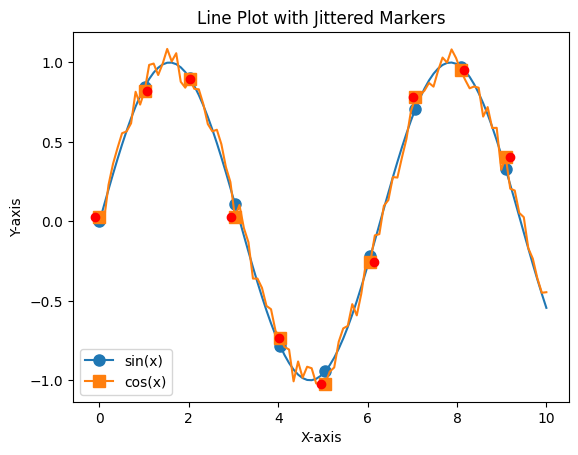

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data: multiple lines
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
#y2 = np.cos(x)
y2 = y1 + np.random.uniform(-0.1, 0.1, 100)

# Define a function to add jitter to the x-locations of the markers
def add_jitter(x, jitter_amount=0.1):
    return x + np.random.uniform(-jitter_amount, jitter_amount, size=x.shape)

# Create a figure and an axes object
fig, ax = plt.subplots()

# Plot the first line with markers every 10th point
ax.plot(x, y1, label='sin(x)', marker='o', markevery=10, markersize=8)

# Plot the second line with markers every 10th point, with jittered x-locations
markers_on = np.arange(0, len(x), 10)
ax.plot(x, y2, label='cos(x)', marker='s', markevery=markers_on, markersize=8)
#ax.plot(x, y2, label='cos(x)',  markevery=markers_on, markersize=8)
ax.scatter(add_jitter(x[markers_on]), y2[markers_on], color='red', zorder=5)

# Add labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Line Plot with Jittered Markers')
ax.legend()

# Show the plot
plt.show()


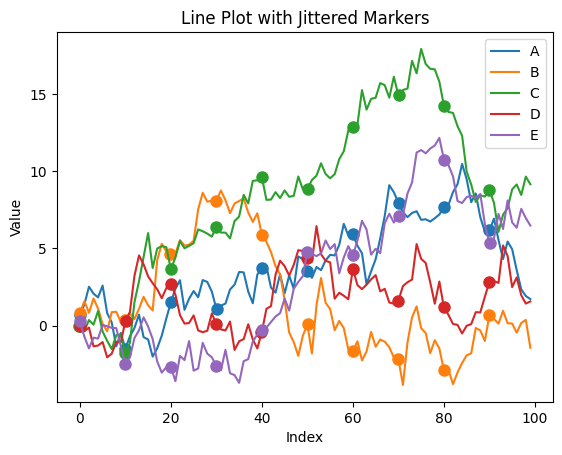

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data: dictionary of arrays
data = {
    'A': np.random.randn(100).cumsum(),
    'B': np.random.randn(100).cumsum(),
    'C': np.random.randn(100).cumsum(),
    'D': np.random.randn(100).cumsum(),
    'E': np.random.randn(100).cumsum()
}

# Function to add jitter to the x-locations of the markers
def add_jitter(x, jitter_amount=0.1):
    return x + np.random.uniform(-jitter_amount, jitter_amount, size=x.shape)

# Create a figure and an axes object
fig, ax = plt.subplots()

# Plot each line with markers every 10th step and jittered markers
for label, y in data.items():
    x = np.arange(len(y))
    line, = ax.plot(x, y, label=label)
    markers_on = np.arange(0, len(x), 10)
    jittered_x = add_jitter(x[markers_on])
    ax.plot(jittered_x, y[markers_on], marker='o', linestyle='None', markersize=8, color=line.get_color())

# Add labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Value')
ax.set_title('Line Plot with Jittered Markers')
ax.legend()

# Show the plot
plt.show()


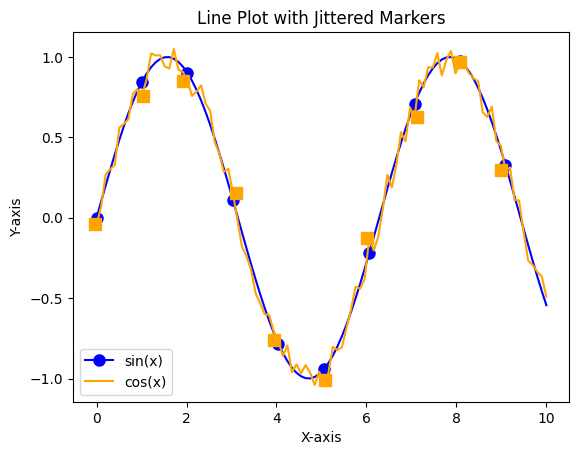

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data: multiple lines
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)
y2 = y1 + np.random.uniform(-0.1, 0.1, 100)

# Define a function to add jitter to the x-locations of the markers
def add_jitter(x, jitter_amount=0.1):
    return x + np.random.uniform(-jitter_amount, jitter_amount, size=x.shape)

# Create a figure and an axes object
fig, ax = plt.subplots()

# Plot the first line with markers every 10th point
line1, = ax.plot(x, y1, label='sin(x)', color='blue', marker='o', markevery=10, markersize=8)

# Plot the second line without markers
line2, = ax.plot(x, y2, label='cos(x)', color='orange')

# Add markers for the second line with jittered x-locations, matching the line color
markers_on = np.arange(0, len(x), 10)
ax.plot(add_jitter(x[markers_on]), y2[markers_on], 's', linestyle='None', markersize=8, color=line2.get_color())

# Add labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Line Plot with Jittered Markers')
ax.legend()

# Show the plot
plt.show()


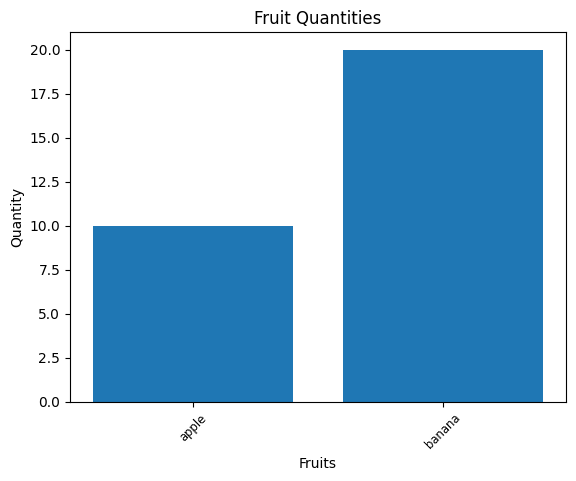

In [2]:
import matplotlib.pyplot as plt

# Sample dictionary
d = {'apple': 10, 'banana': 20}

# Extract keys and values
keys = list(d.keys())
values = list(d.values())

# Create a bar chart
plt.bar(keys, values)

# Rotate x-axis labels by 45 degrees and set font size to small
plt.xticks(rotation=45, fontsize='small')

# Add labels and title
plt.xlabel('Fruits')
plt.ylabel('Quantity')
plt.title('Fruit Quantities')

# Show the plot
plt.show()


In [17]:
parser = argparse.ArgumentParser()

# Data parameters
parser.add_argument("--dataset", type=str, default="reg") 
parser.add_argument("--data_dim", type=int, default=10)
parser.add_argument("--data_key", type=int, default=0)
parser.add_argument("--dgp_type", type=str, default="lin") # or mlp
parser.add_argument("--dgp_neurons", type=int, nargs="+", default=[20, 20, 1]) 
parser.add_argument("--dgp_neurons_str", type=str, default="") # 20_20_1 
parser.add_argument("--emission_noise", type=float, default=1.0)
parser.add_argument("--ntrain", type=int, default=500)
parser.add_argument("--nval", type=int, default=500)
parser.add_argument("--ntest", type=int, default=1000)
parser.add_argument("--add_ones", type=bool, default=False)


# Model parameters
parser.add_argument("--agent", type=str, default="bong_fc", choices=AGENT_NAMES)
parser.add_argument("--agent_key", type=int, default=0)
parser.add_argument("--lr", type=float, default=0.01)
parser.add_argument("--niter", type=int, default=10) 
parser.add_argument("--nsample", type=int, default=10) 
parser.add_argument("--ef", type=int, default=0)
parser.add_argument("--linplugin", type=int, default=0)
parser.add_argument("--rank", type=int, default=10)
parser.add_argument("--model_type", type=str, default="lin") # or mlp
parser.add_argument("--model_neurons", type=int, nargs="+", default=[1])
parser.add_argument("--model_neurons_str", type=str, default="") 
parser.add_argument("--init_var", type=float, default=1.0)
parser.add_argument("--algo_key", type=int, default=0)

# results
parser.add_argument("--dir", type=str, default="", help="directory to store results") 
parser.add_argument("--debug", type=bool, default=False)


args = parser.parse_args([])

In [18]:
from datasets import *
from models import *
from bong.agents import *
from run_job import *

data = make_dataset(args)
print(data['X_tr'].shape)

model = make_model(args, data)

constructor = AGENT_DICT[args.agent]['constructor']
agent = constructor(
                    **model['model_kwargs'],
                    agent_key = args.agent_key,
                    learning_rate = args.lr,
                    num_iter = args.niter,
                    num_samples = args.nsample,
                    linplugin = args.linplugin,
                    empirical_fisher = args.ef,
                    rank = args.rank
                )
key = jr.PRNGKey(args.agent_key)
results, elapsed = run_agent(key, agent, data, model)
df = pd.DataFrame(results)
attributes = parse_agent_full_name(agent.name)
meta = { # non time-series data
    'data_name': data['name'],
    'model_name': model['name'],
    'agent_name': agent.name,
    'algo': attributes['algo'],
    'param': attributes['param'],
    'elapsed': elapsed
    }


(500, 10)
Running bong_fc-MC10-I1-LR0-EF1-Lin0 + mlp_10_1 on reg-D10-lin_1
Using GPU of type:  None
Time 15.75s
Test NLL: 1.5503,  NLPD: 1.5489
Val NLL 1.5632,  NLPD: 1.5948


In [13]:
from process_jobs import *

root_dir = '/teamspace/studios/this_studio/jobs'
data_dir = 'reg-D10-mlp_20_20_1'
model_dir = 'mlp_1'
agent_dir = 'A:bong-P:fc-Lin:0-LR:0_01-IT:10-MC:100-EF:0-R:0/'
dir = f'{root_dir}/{data_dir}/{model_dir}/{agent_dir}'



    
df = create_results_summary(dir)
df.head()





,jobname,agent_name,model_name,data_name,elapsed,summary
0,job0-00,bong_fc-MC100-I1-LR0-EF0-Lin0,mlp_1,reg-D10-mlp_20_20_1,1.406131,"Test NLL: 1.4352, NLPD: 1.4501\nVal NLL 1.436..."
